In [52]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Download dataset 1) MutSpec of vertebrates and 2) asymmetry in nuclear genome

In [21]:
assymetry = pd.read_table('../data/external/T-R_plot_allCpG.txt', sep=' ', header=None)
mut_vert = pd.read_csv('../data/MutSpecALLvert.csv')

In [34]:
mut_vert['MutBase'] = mut_vert.Mut.str.slice(2,5)
mut_vert['AncestorCodon'] = mut_vert.Mut.str.get(0) + mut_vert.Mut.str.get(2) + mut_vert.Mut.str.get(-1)
mut_vert.head()

,Mut,MutSpec,MutBase,AncestorCodon
0,A[A>C]A,0.000424,A>C,AAA
1,A[A>C]C,0.001497,A>C,AAC
2,A[A>C]G,0.000197,A>C,AAG
3,A[A>C]T,0.000000,A>C,AAT
4,A[A>G]A,0.014522,A>G,AAA


In [25]:
assymetry = assymetry.rename(columns={0:'AncestorCodon', 1:'MutBase', 2:'T', 3:'R'})
assymetry.head()

,AncestorCodon,MutBase,T,R
0,ACA,C>A,-0.171181,-0.373510
1,ACA,C>G,0.065067,0.034147
2,ACA,C>T,-0.012015,-0.052744
3,ACC,C>A,-0.091167,-0.285840
4,ACC,C>G,0.091991,0.144789


In [45]:
def gettranslate(mut, reverse=True):
    translator = str.maketrans("ACGT", "TGCA")
    if reverse is True:
        mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = mut.translate(translator)
    return new_mut

In [59]:
to_96_comp = []
for num_subs in range(0,96):
    # define ancestral and mutbase from mutspec according on 96 comp from asymmetry
    anc = assymetry.iloc[num_subs, 0]
    mb = assymetry.iloc[num_subs, 1]
    # get reverse subs with context
    rev_anc = gettranslate(anc, reverse=True)
    rev_mb = gettranslate(mb, reverse=False)
    # find mutspec num for the mutbase and context same with reverse, than devide on reverse
    rev_mutspec = mut_vert[(mut_vert.MutBase == rev_mb) & (mut_vert.AncestorCodon == rev_anc)].MutSpec.values[0]
    mutspec = mut_vert[(mut_vert.MutBase == mb) & (mut_vert.AncestorCodon == anc)].MutSpec.values[0]
    new_96_mut = mutspec/rev_mutspec
    #define row for future df
    out_mut = {'AncestorCodon': anc, 'MutBase': mb, 'MutSpec': new_96_mut}
    to_96_comp.append(out_mut)

mut_96_comp = pd.DataFrame(to_96_comp)
mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].replace(np.inf, 0)
mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].fillna(0)
mut_96_comp.head()
    

/var/folders/5l/9jtg_90x5s575m1zqn_h0kgm0000gn/T/ipykernel_14586/3797007472.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/5l/9jtg_90x5s575m1zqn_h0kgm0000gn/T/ipykernel_14586/3797007472.py:12: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec


,AncestorCodon,MutBase,MutSpec
0,ACA,C>A,0.000000
1,ACA,C>G,0.000000
2,ACA,C>T,3.473528
3,ACC,C>A,0.000000
4,ACC,C>G,0.000000


In [61]:
final_asymmetry = assymetry.merge(right = mut_96_comp, on=['AncestorCodon', 'MutBase'])
final_asymmetry.head()

,AncestorCodon,MutBase,T,R,MutSpec
0,ACA,C>A,-0.171181,-0.373510,0.000000
1,ACA,C>G,0.065067,0.034147,0.000000
2,ACA,C>T,-0.012015,-0.052744,3.473528
3,ACC,C>A,-0.091167,-0.285840,0.000000
4,ACC,C>G,0.091991,0.144789,0.000000


In [105]:
t_cor = stats.spearmanr(final_asymmetry['T'].values, final_asymmetry.MutSpec.values, axis=0)

In [106]:
r_cor = stats.spearmanr(final_asymmetry['R'].values, final_asymmetry.MutSpec.values)

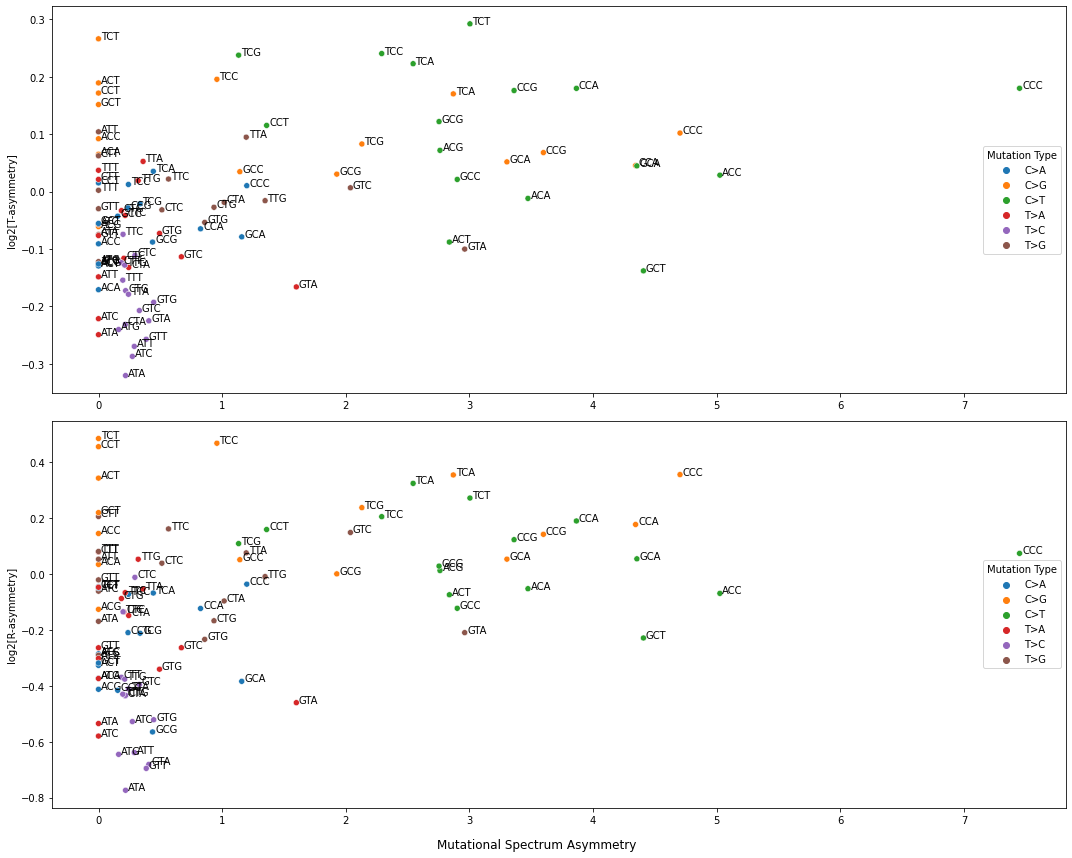

In [213]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

fig, axs = plt.subplots(2)
fig.set_figheight(12)
fig.set_figwidth(15)
sns.scatterplot(data = final_asymmetry, x='MutSpec', y='T', hue='MutBase', ax=axs[0])
label_point(final_asymmetry.MutSpec, final_asymmetry['T'], final_asymmetry.AncestorCodon, axs[0])
axs[0].legend(loc='center right', title='Mutation Type')
axs[0].set_xlabel('')
axs[0].set_ylabel('log2[T-asymmetry]')
sns.scatterplot(data = final_asymmetry, x='MutSpec', y='R', hue='MutBase', ax=axs[1])
label_point(final_asymmetry.MutSpec, final_asymmetry['R'], final_asymmetry.AncestorCodon, axs[1])
axs[1].legend(loc='center right', title='Mutation Type')
axs[1].set_xlabel('')
axs[1].set_ylabel('log2[R-asymmetry]')
fig.supxlabel('Mutational Spectrum Asymmetry')
plt.tight_layout()
fig.savefig('../pictures/AsymmetryTRM.pdf', dpi=300)

In [79]:
final_asymmetry.to_csv('../data/asymmetry_mutspec.csv', index=False)

### Damage analysis

In [83]:
main_subs = ['C>T', 'A>G', 'G>T', 'A>T', 'C>G', 'A>C']

In [90]:
damage = []
for mutbase in main_subs:
    cont_mb = mut_vert[mut_vert.MutBase == mutbase].Mut
    for context in cont_mb:
        mutspec_main = mut_vert[mut_vert.Mut == context].MutSpec.values[0]
        mutspec_rev = mut_vert[mut_vert.Mut == gettranslate(context, reverse=True)].MutSpec.values[0]
        out_damage = {'Mut':context,'ReverseMut':gettranslate(context, reverse=True), 'MutSpecDif':mutspec_main-mutspec_rev}
        damage.append(out_damage)
damage = pd.DataFrame(damage)
damage.head()

,Mut,ReverseMut,MutSpecDif
0,A[C>T]A,T[G>A]T,0.024372
1,A[C>T]C,G[G>A]T,0.029733
2,A[C>T]G,C[G>A]T,0.015401
3,A[C>T]T,A[G>A]T,0.011718
4,C[C>T]A,T[G>A]G,0.025892


In [91]:
damage.MutSpecDif.sum()

0.5245771260547207